# Cell Ranger의 기본 파이프라인 

1. **FASTQ parsing**
* R1: Cell Barcode + UMI
* R2: cDNA read (actual transcript sequence)
* whitelist된 cell barcode만 유효한 셀로 취급.

2. **Alignment**
* R2를 reference genome에 align (STAR aligner 기반).
* 유효한 read만 BAM에 기록.

3. **Correction / QC**
* cell barcode는 whitelist 기반으로 nearest-neighbor correction.
* UMI는 sequencing error 교정 (예: 1-bp mismatch clustering).
* low-quality cells (low # of UMIs, high MT%) 필터링.

4. **Counting**
* (cell barcode, UMI, gene) 조합을 unique하게 세어 gene expression matrix 생성.

In [1]:
# 1. 필요한 라이브러리 불러오기
import gzip
import collections
import tables
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.io import mmread
from scipy.sparse import csr_matrix
import h5py
import matplotlib.pyplot as plt

### 사용 데이터: 1k PBMCs from a Healthy Donor (v3 chemistry)
* 10k는 fastq파일이 무겁다보니 빠르게 hands-on 위해 비교적 가벼운 1k 선택
* Available at 10x Genomics: mannually download from [here](https://www.10xgenomics.com/datasets/1-k-pbm-cs-from-a-healthy-donor-v-3-chemistry-3-standard-3-0-0)

## 1. FASTQ Parsing 

* `R1`: Cell Barcode + UMI (보통 28bp = 16bp barcode + 12bp UMI)

* `R2`: cDNA (transcript sequence), 즉 실제 유전자 서열 -> 유전자 alignment / transcript 정보

* `L001`, `L002` … : sequencing lane 번호 (하나의 시퀀싱 런이 여러 lane으로 쪼개질 수 있음)

* `_001` : read chunk 번호 (한 lane에서 파일을 여러 개로 쪼개 저장했을 때)

* `I1`/`I2`: sample index → multiplexed sequencing에서 어떤 sample인지 구분하는데 사용, PBMC 단일 샘플이면 분석에 필요 없음

In [2]:
import os

fastq_folder = "data/pbmc_1k_v3_fastqs"

fastq_files = sorted([f for f in os.listdir(fastq_folder) if f.endswith(".fastq.gz")])
print("FASTQ R1 파일 목록:")
for f in fastq_files:
    print(f)

# 각 파일에서 첫 4개의 read 살펴보기 (FASTQ 구조 확인)
for f in fastq_files:
    print(f"\n============ {f} ============")
    with gzip.open(os.path.join(fastq_folder, f), "rt") as fq:
        for i in range(6):
            header = fq.readline().strip()
            seq = fq.readline().strip()
            plus = fq.readline().strip()
            qual = fq.readline().strip()
            print(header)
            print(seq)
            print(plus)
            print(qual)
    print("=============================")

FASTQ R1 파일 목록:
pbmc_1k_v3_S1_L001_I1_001.fastq.gz
pbmc_1k_v3_S1_L001_R1_001.fastq.gz
pbmc_1k_v3_S1_L001_R2_001.fastq.gz
pbmc_1k_v3_S1_L002_I1_001.fastq.gz
pbmc_1k_v3_S1_L002_R1_001.fastq.gz
pbmc_1k_v3_S1_L002_R2_001.fastq.gz

============ pbmc_1k_v3_S1_L001_I1_001.fastq.gz ============
@A00228:279:HFWFVDMXX:1:1101:8486:1000 1:N:0:NCATTACT
NCATTACT
+
#FFFFFFF
@A00228:279:HFWFVDMXX:1:1101:10782:1000 1:N:0:NCATTACT
NCATTACT
+
#FFFFFFF
@A00228:279:HFWFVDMXX:1:1101:12626:1000 1:N:0:NCATTACT
NCATTACT
+
#FFFFFFF
@A00228:279:HFWFVDMXX:1:1101:14452:1000 1:N:0:NCATTACT
NCATTACT
+
#FFFFFFF
@A00228:279:HFWFVDMXX:1:1101:24071:1000 1:N:0:NCATTACT
NCATTACT
+
#FFFFFFF
@A00228:279:HFWFVDMXX:1:1101:32461:1000 1:N:0:NCATTACT
NCATTACT
+
#FFFFFFF

============ pbmc_1k_v3_S1_L001_R1_001.fastq.gz ============
@A00228:279:HFWFVDMXX:1:1101:8486:1000 1:N:0:NCATTACT
NGTGATTAGCTGTACTCGTATGTAAGGT
+
#FFFFFFFFFFFFFFFFFFFFFFFFFFF
@A00228:279:HFWFVDMXX:1:1101:10782:1000 1:N:0:NCATTACT
NTCATGAAGTTTGGCTAGTTATGTTCAT
+
#

In [3]:
def read_all_r1_fastq(barcode_umi_folder, max_reads_per_file=None):
    """
    폴더 안 모든 R1 FASTQ 파일을 읽어서 (cell barcode, UMI) Counter 생성
    - R1 파일만 자동 선택
    - max_reads_per_file: 각 파일에서 최대 읽을 read 수 (샘플링용)
    """
    barcode_umi_counts = collections.Counter()
    
    # R1 FASTQ만 골라서 정렬
    fastq_files = sorted([f for f in os.listdir(barcode_umi_folder) 
                          if f.endswith(".fastq.gz") and "_R1_" in f])
    
    if not fastq_files:
        print("폴더 안에 R1 FASTQ 파일이 없습니다!")
        return barcode_umi_counts
    
    print(f"Found {len(fastq_files)} R1 FASTQ files.")
    
    for f in fastq_files:
        file_path = os.path.join(barcode_umi_folder, f)
        print(f"Processing {f} ...")
        with gzip.open(file_path, "rt") as fq:
            count = 0
            while True:
                header = fq.readline().strip()
                if not header:
                    break
                seq = fq.readline().strip()
                fq.readline()  # +
                fq.readline()  # quality
                
                # 10x v3 chemistry 기준: 16bp cell barcode + 12bp UMI
                cell_barcode = seq[:16]
                umi = seq[16:28]
                barcode_umi_counts[(cell_barcode, umi)] += 1
                
                count += 1
                if max_reads_per_file and count >= max_reads_per_file:
                    break
    
    print(f"총 unique (cell barcode, UMI) 조합: {len(barcode_umi_counts)}")
    return barcode_umi_counts

In [4]:
barcode_umi_counts = read_all_r1_fastq(fastq_folder, max_reads_per_file=50000)

Found 2 R1 FASTQ files.
Processing pbmc_1k_v3_S1_L001_R1_001.fastq.gz ...
Processing pbmc_1k_v3_S1_L002_R1_001.fastq.gz ...
총 unique (cell barcode, UMI) 조합: 91732


In [5]:
def barcode_umi_summary(barcode_umi_counts, top_n):
    """
    barcode+UMI Counter를 DataFrame으로 변환하고 요약
    """
    # Counter -> DataFrame
    df = pd.DataFrame(
        list(barcode_umi_counts.items()),
        columns=["cell_barcode_UMI", "count"]
    )
    
    # cell barcode, UMI 분리
    df["cell_barcode"] = df["cell_barcode_UMI"].apply(lambda x: x[0])
    df["UMI"] = df["cell_barcode_UMI"].apply(lambda x: x[1])
    
    # cell barcode 기준으로 UMI 개수 합계
    barcode_summary = df.groupby("cell_barcode")["count"].sum().reset_index()
    barcode_summary = barcode_summary.sort_values(by="count", ascending=False)
    
    print(f"총 unique cell barcode: {barcode_summary.shape[0]}")
    print(f"상위 {top_n} cell barcode:")
    display(barcode_summary.head(top_n))
    
    # histogram
    plt.figure(figsize=(6,4))
    plt.hist(barcode_summary["count"], bins=50, color='skyblue', log=True)
    plt.xlabel("UMI count per cell barcode")
    plt.ylabel("Number of cell barcodes (log scale)")
    plt.title("Distribution of UMI counts per cell barcode")
    plt.show()
    
    return df, barcode_summary

총 unique cell barcode: 10167
상위 None cell barcode:


,cell_barcode,count
3824,CGAGAAGTCAAGTTGC,453
5412,GATCACACACCCTGTT,428
4229,CTACAGACAACAAAGT,344
6488,GGTTGTATCGAAGGAC,274
3459,CCGATGGGTTCTCGCT,238
...,...,...
3742,CCTGGTAGTCGTGTTA,1
3743,CCTGTCGGTGTGCCTG,1
3744,CCTGTTGACTGGATCT,1
3745,CCTGTTGAGCTGAGCA,1


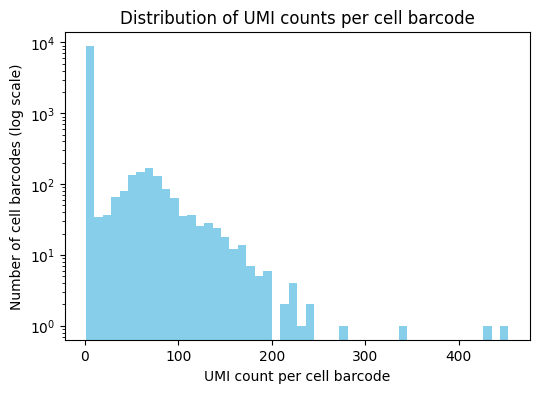

In [6]:
# barcode_umi_counts = read_all_r1_fastq(fastq_folder, max_reads_per_file=50000)
df_counts, barcode_summary = barcode_umi_summary(barcode_umi_counts, top_n=None)

In the [10x genomics](https://www.10xgenomics.com/datasets/10-k-pbm-cs-from-a-healthy-donor-v-3-chemistry-3-standard-3-0-0) ...
* it says **1,222 cells** were detected..
* How come?!